# Base

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import seaborn as sns
from tqdm import tqdm
from torchinfo import summary

In [ ]:
DIR_DATA="/content/data/Dataset/" #Path where your dataset files are stored, this folder contains WESADECG_S2.json,WESADECG_S3.json,...WESADECG_Sk.json files
DIR_NET_SAVING="/content/data/net/" #Path where model's weights are saved for each training
DIR_RESULTS="/content/data/" #Path to save Results of the network (loss function)

In [ ]:
manualSeed=1
torch.manual_seed(manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
g = torch.Generator()
g.manual_seed(manualSeed)

# Functions

In [4]:
def suppr(dic):
  """ Delete extremums (irrelevant extract due to weird peak detections) from a dictionnary (a subject)  
  """
  bornemax=np.quantile(dic["features"],0.99,axis=0)
  bornemin=np.quantile(dic["features"],0.01,axis=0)
  indicesmauvais=np.where(np.sum(np.add(bornemin>np.array(dic["features"]),np.array(dic["features"])>bornemax),axis=1)>0)[0]
  k=0

  for i in indicesmauvais:
    del dic["features"][i-k]
    del dic["label"][i-k]
    k+=1

  return dic

def extract_ds_from_dict(data):
  """ Delete the irrelevant extract for each state and return the dataset as a dictionnary"""
  Letat=[]

  for i in range(0,4):
    dictio={}
    features=[data["features"][j] for j in np.where(np.array(data["label"])==i+1)[0]] 
    label=[data["label"][j] for j in np.where(np.array(data["label"])==i+1)[0]]
    dictio["features"]=features
    dictio["label"]=label
    Letat.append(dictio.copy())

  neutr=Letat[0]
  stress=Letat[1]
  amu=Letat[2]
  med=Letat[3]
  neutr=suppr(neutr)
  stress=suppr(stress)
  amu=suppr(amu)
  med=suppr(med)
  features=[]
  label=[]
  dict_id={}

  for m in range(0,4):
    dictio=Letat[m]
    features+=[x for x in dictio["features"]] 
    label+=[x for x in dictio["label"]]

  dict_id["features"]=features
  dict_id["label"]=label
  return dict_id.copy()

def conf_mat(net,datal,trsh):
  """ Compute 2 confusion matrixes according to a dataloader and a threshold for state prediction (above the threshold the subject is 
  under stress condition) 
  
  2x2 confusion matrix : Stress and No stress as label for line and column
  3x4 confusion matrix : {Total ; Stress ; No stress} as label for the lines
                         {Neutral ; Stress ; Amusement; Meditation} as label for the columns
  """
  x=datal[0].float().to(device)
  y=net(x).view(-1)
  pred=(y>trsh).int()
  label=datal[1].float().to(device).view(-1).int()
  num=datal[2].float().to(device).int()
  comp=torch.eq(label,pred).int()
  mat_label=np.zeros((3,4))
  mat_nolbl=np.zeros((2,2))

  for i in range(0,4):
    tens=torch.where(num==i+1,1,0)
    numtot=torch.sum(tens).item()
    num_G=torch.sum(torch.where(torch.mul(tens,comp)==1,1,0)).item()

    if i ==1:
      mat_nolbl[0,0]+=num_G
      mat_nolbl[1,0]+=numtot-num_G
      mat_label[0,i]=numtot
      mat_label[1,i]=num_G
      mat_label[2,i]=numtot-num_G

    else:
      mat_nolbl[1,1]+=num_G
      mat_nolbl[0,1]+=numtot-num_G
      mat_label[0,i]=numtot
      mat_label[2,i]=num_G
      mat_label[1,i]=numtot-num_G


  return mat_label,mat_nolbl

def fusion_dic(list_dic):
  """ Merge dictionnaries (dataset) from a list (each dictionnary represent the dataset of a subject """
  features=[]
  label=[]
  dic_f={}

  for dic in list_dic:
    features+=dic["features"]
    label+=dic["label"]

  dic_f["features"]=features
  dic_f["label"]=label
  return dic_f

def proportion(dic, indice, prop):
  """ Return a balanced dataset (reduced by the factor prop) for a balanced training"""
  tot=len(indice)
  features=[dic["features"][j] for j in indice[::int(np.ceil(tot/prop))]]
  label=[dic["label"][j] for j in indice[::int(np.ceil(tot/prop))]]
  return features,label

def eq_dic(dic):
  """ Return a balanced dataset from the dictionnary of a subject (same ammount of data for neutral/stress/amusement/relax condition)"""
  indice_neutr=np.where(np.array(dic["label"])==1)[0]
  indice_stress=np.where(np.array(dic["label"])==2)[0]
  indice_amu=np.where(np.array(dic["label"])==3)[0]
  indice_med=np.where(np.array(dic["label"])==4)[0]
  nbr_neutr=len(indice_neutr)
  nbr_stress=len(indice_stress)
  nbr_amu=len(indice_amu)
  nbr_med=len(indice_med)
  prop=min([3*nbr_neutr,nbr_stress,3*nbr_amu,3*nbr_med])
  prop_stress=prop
  prop_neutr=int(0.333*prop)
  prop_amu=int(0.333*prop)
  prop_med=int(0.333*prop)
  features=[]
  label=[]
  dic_f={}
  tempf,templ=proportion(dic,indice_neutr,prop_neutr)
  features+=tempf
  label+=templ
  tempf,templ=proportion(dic,indice_stress,prop_stress)
  features+=tempf
  label+=templ
  tempf,templ=proportion(dic,indice_amu,prop_amu)
  features+=tempf
  label+=templ
  tempf,templ=proportion(dic,indice_med,prop_med)
  features+=tempf
  label+=templ
  dic_f["features"]=features
  dic_f["label"]=label
  return dic_f

# DS creation kfold

In [5]:
class ds_wesad(Dataset):
    """ Define the Dataset object for the WESAD (feature vector;is_stressed(0/1);emotionnal_state(0;1;2;3)
    
    0 neutral
    1 stress
    2 amusement
    3 relax
    
    """
    def __init__(self, dic):
        self.samples = []
        self.dic=dic
        for i in range(0,len(dic["label"])):
            num=dic["label"][i]
            stress=num==2
            x=np.array(dic["features"][i])
            self.samples.append((x,int(stress),num))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, id):
        return self.samples[id]

In [ ]:
"""Handles the cross validation process, generates the multiple training and validation data dictionnaries for the cross validation"""

name_list= ['WESADECG_S2.json', 'WESADECG_S3.json', 'WESADECG_S4.json', 'WESADECG_S5.json', 'WESADECG_S6.json', 'WESADECG_S7.json',
 'WESADECG_S8.json', 'WESADECG_S9.json', 'WESADECG_S10.json', 'WESADECG_S11.json', 'WESADECG_S13.json', 'WESADECG_S14.json',
 'WESADECG_S15.json', 'WESADECG_S16.json']


#assert (len(name_list)==14)  ONE Subject for testing S17
list_dic_ds=[]
cntr=0

for k in range(0,14):
  for j in range(k,14):

    if k!=j :  
      f1 = open(DIR_DATA+name_list[k])
      f2 = open(DIR_DATA+name_list[j])
      data_1 = json.load(f1)
      data_2 = json.load(f2)
      dic_3=fusion_dic([data_1,data_2])
      dic_v=extract_ds_from_dict(dic_3)  #Create a validation dictionnary made from the data of 2 subject (some data of the subject are deleted because they are irrelevant due to misfunction of sensors/impossible values)
      L=[]

      for i in range(0,len(name_list)):
        if (i!=k and i!=j):
          f=open(DIR_DATA+name_list[i])
          data = json.load(f)
          dic=eq_dic(data)
          L.append(dic)

      assert (len(L)==12)
      dic_4=fusion_dic(L)
      dic_t=extract_ds_from_dict(dic_4)
      list_dic_ds.append([dic_t,dic_v,k,j]) #Create a training dictionnary made from the data of 12 subjects, all of the data are balanced and extract with impossible (physically) values are deleted
      cntr+=1
      if cntr%10==0:
        print(cntr)

In [7]:
""" Generate the multiple datasets object for each data dictionnary (first on is training dataset, second is validation dataset)"""
list_ds=[]
cntr=0
for sample in list_dic_ds:
  list_ds.append([ds_wesad(sample[0]),ds_wesad(sample[1]),sample[2],sample[3]]) #[training dataset; validation dataset(from subjects k and j); k; j]
  cntr+=1

# Model

In [8]:
from torch.nn.modules.activation import LeakyReLU
""" DNN Model """

def init_weight(m):
    """Initialization of the weights"""
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_() 

class ClassifierECG(nn.Module):
    """DNN model, see the model architecture in the report for more details"""
    def __init__(self, ngpu):
        super(ClassifierECG, self).__init__()
        self.ngpu = ngpu
        self.nnECG = nn.Sequential(
            nn.Linear(12,128,bias=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(128,64,bias=True),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(64,16,bias=True),
            nn.BatchNorm1d(16),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(16,4,bias=True),
            nn.BatchNorm1d(4),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(4,1,bias=True),
            nn.Sigmoid()
        )
        self.nnECG.apply(init_weight)

    def forward(self, input):
        return self.nnECG(input)

# Training

In [ ]:
def training(net,dataloader_t,dataloader_v,num_epochs,j,k):
  """ Training with a BCELoss on the dataset, for each epoch the net weights are saved and the mean error is computed to plot the loss
  for training and valdiation dataset
  """
  Loss = []
  Lossv= []
  for epoch in range(num_epochs):
      L_t=[]
      L_v=[]
      for i, dataj in enumerate(dataloader_t, 0):
          net.zero_grad()
          x=dataj[0].float().to(device)
          yhat=dataj[1].float().to(device)
          yhat=yhat.view(-1,1)
          y=net(x)
          err_t=nn.BCELoss()(y.float(),yhat.float())
          err_t.backward()
          optimizer.step()
          L_t.append(err_t.item())
      for i, dataj in enumerate(dataloader_v, 0):
        net.eval()     
        x=dataj[0].float().to(device)
        yhat=dataj[1].float().to(device)
        yhat=yhat.view(-1,1)
        y=net(x)
        err_v=nn.BCELoss()(y.float(),yhat.float())
        L_v.append(err_v.item())
      err=np.mean(L_t)
      errv=np.mean(L_v)
      Loss.append(err)
      Lossv.append(errv)
      torch.save(net.state_dict(), DIR_NET_SAVING+"net_"+str(j)+"_"+str(k)+"_epoch_"+str(epoch)+".pth")
  return [Lossv,np.argmin(Lossv)]

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

num_workers = 2
batch_size = 32
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")  

L=[]    
cntr=0

for ds in tqdm(list_ds):
  net= ClassifierECG(ngpu).to(device)
  lr=0.0001
  beta1=0.9
  optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
  dataset_t=ds[0]
  dataset_v=ds[1]
  k=ds[2]
  j=ds[3]
  dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  L.append(training(net,dataloader_t,dataloader_v,15,j,k))

# Save Results

In [ ]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [ ]:
with open(DIR_RESULTS+"results.json","w") as file:
    json.dump(L,file,cls=NpEncoder)

# Load Results

In [10]:
with open(DIR_RESULTS+"results.json","r") as file:
    L=json.load(file)

In [13]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
num_workers = 2
batch_size = 32
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")  

0
10
20
30
40
50
60
70
80
90


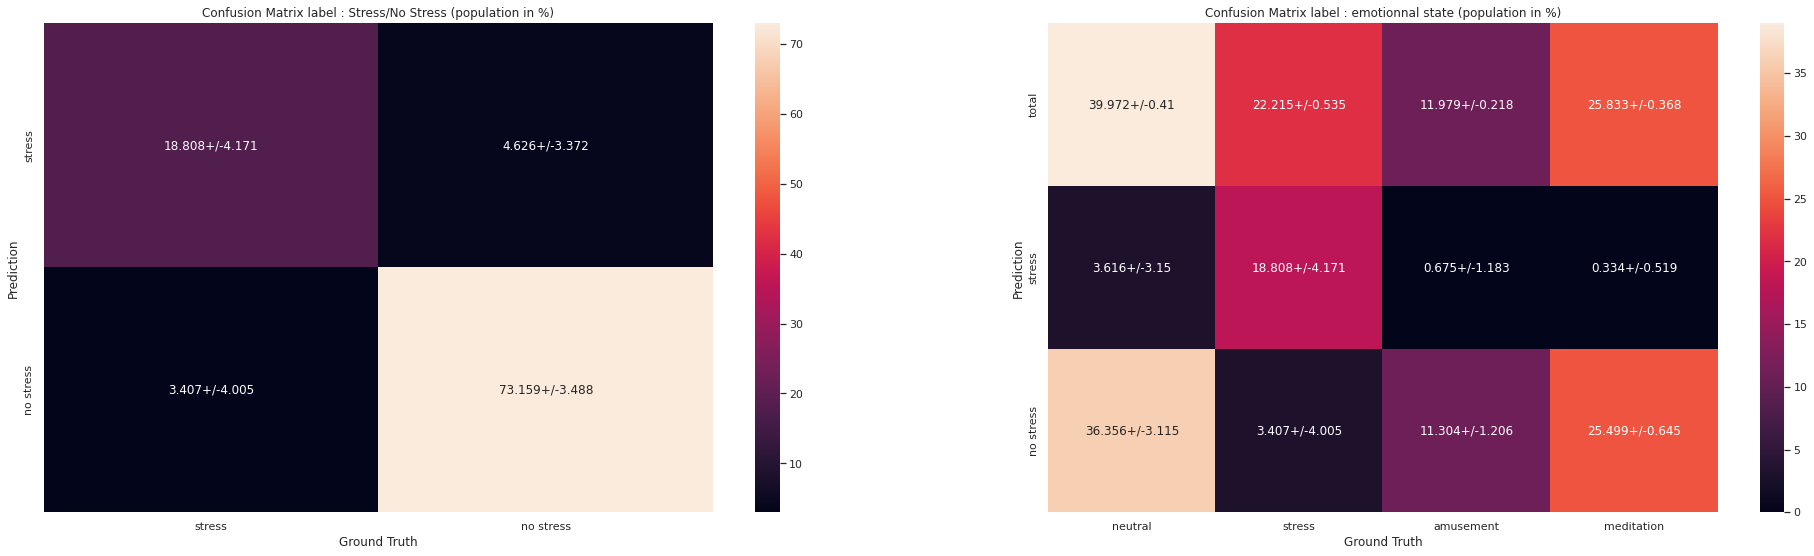

In [20]:
"""
This cell compute the confusion matrixes (one with no label and one with label) with the best model of each fold (91 folds)
=> (prediction of the network as line label and true emotional state as column label)
The ploted matrixes are the mean+/-std of all the confusion matrixes (all folds)

This cell also compute the accuracy, precision, recall and F1 score of each fold model and stores these metrics in a list
"""

confusionlabelmean=np.zeros((3,4))
confusionmean=np.zeros((2,2))
acc_list=[]
prec_list=[]
recall_list=[]
f1_list=[]
confusion_label_list=[]
confusion_list=[]

for n in range(0,len(L)):
  if n%10==0:
    print(n)
  k=list_ds[n][2]
  j=list_ds[n][3]
  dataset_t=list_ds[n][0]
  dataset_v=list_ds[n][1]
  epch=np.argmin(L[n][0])
  net= ClassifierECG(ngpu).to(device)
  lr=0.0001
  beta1=0.9
  optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
  net.load_state_dict(torch.load(DIR_NET_SAVING+"net_"+str(j)+"_"+str(k)+"_epoch_"+str(epch)+".pth"))
  dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  trsh=0.5
  net.eval()
  confusionlabel=np.zeros((3,4))
  confusion=np.zeros((2,2))
  length_dsv=0
  for i, datal in enumerate(dataloader_v, 0):
        confusionlabelt,confusiont=conf_mat(net,datal,trsh)
        confusion+=confusiont
        confusionlabel+=confusionlabelt 
        length_dsv+=batch_size

  TP=confusion[0,0]
  TN=confusion[1,1]
  FN=confusion[1,0]
  FP=confusion[0,1]
  acc=(TP+TN)/(TP+FP+FN+TN)
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  F1score=(2*recall*precision)/(recall+precision)
  acc_list.append(acc)
  prec_list.append(precision)
  recall_list.append(recall)
  f1_list.append(F1score)
  confusion_label_list.append(100*confusionlabel/length_dsv)
  confusion_list.append(100*confusion/length_dsv)


confusionmean=np.round(np.mean(confusion_list,axis=0),3)
confusionlabelmean=np.round(np.mean(confusion_label_list,axis=0),3)
confusionstd=np.round(np.std(confusion_list,axis=0),3)
confusionlabelstd=np.round(np.std(confusion_label_list,axis=0),3)
annot_confusion=np.array([str(a)+"+/-"+str(b) for a,b in zip(confusionmean.reshape(-1).tolist(),confusionstd.reshape(-1).tolist())]).reshape(confusionmean.shape)
annot_confusion_label=np.array([str(a)+"+/-"+str(b) for a,b in zip(confusionlabelmean.reshape(-1).tolist(),confusionlabelstd.reshape(-1).tolist())]).reshape(confusionlabelmean.shape)
x_axis_confl = ['neutral','stress','amusement','meditation'] # labels for x-axis
y_axis_confl = ['total','stress','no stress'] # labels for y-axis
x_axis_conf = ['stress','no stress']
y_axis_conf = ['stress','no stress']
sns.set(rc={"figure.figsize":(15, 5)})
fig, axs = plt.subplots(ncols=2,figsize=(33,9))
sns.heatmap(confusionmean.astype('int32'), xticklabels=x_axis_conf, yticklabels=y_axis_conf,annot=annot_confusion,ax=axs[0],fmt = '')
axs[0].set_xlabel('Ground Truth')
axs[0].set_ylabel('Prediction')
axs[0].title.set_text('Confusion Matrix label : Stress/No Stress (population in %)')
sns.heatmap(confusionlabelmean.astype('int32'), xticklabels=x_axis_confl, yticklabels=y_axis_confl, annot=annot_confusion_label,ax=axs[1],fmt = '')
axs[1].set_xlabel('Ground Truth')
axs[1].set_ylabel('Prediction')
axs[1].title.set_text('Confusion Matrix label : emotionnal state (population in %)')

# Metrics :

The 4 following figures are the distribution of accuracy, precision, recall and f1 score of all best models (for each fold)

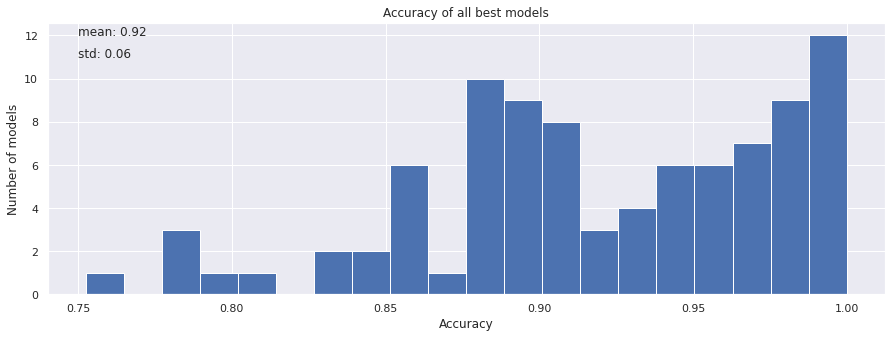

In [15]:
mes=acc_list
plt.hist(mes,bins=20)
plt.title('Accuracy of all best models')
plt.xlabel('Accuracy') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.75, 12, txtm)
plt.text(0.75, 11, txtstd)
plt.show()

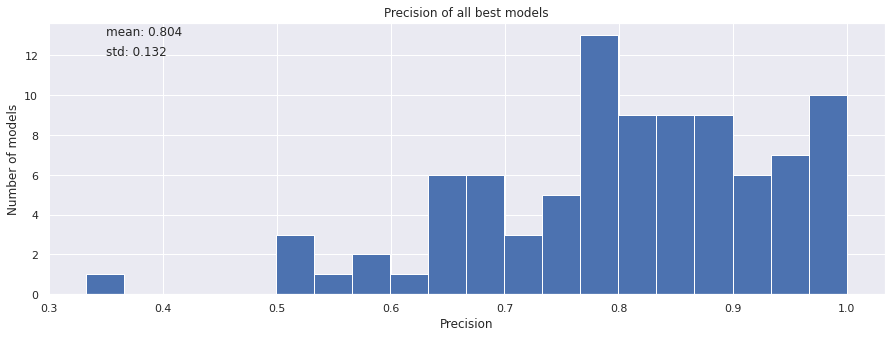

In [16]:
mes=prec_list
plt.hist(mes,bins=20)
plt.title('Precision of all best models')
plt.xlabel('Precision') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.35, 13, txtm)
plt.text(0.35, 12, txtstd)
plt.show()

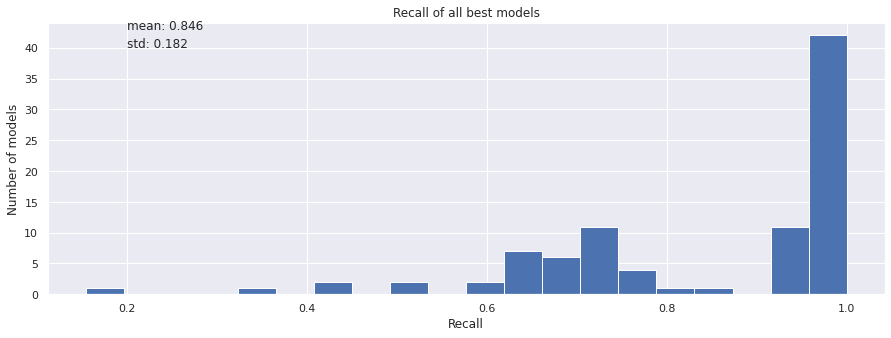

In [17]:
mes=recall_list
plt.hist(mes,bins=20)
plt.title('Recall of all best models')
plt.xlabel('Recall') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.2, 43, txtm)
plt.text(0.2, 40, txtstd)
plt.show()

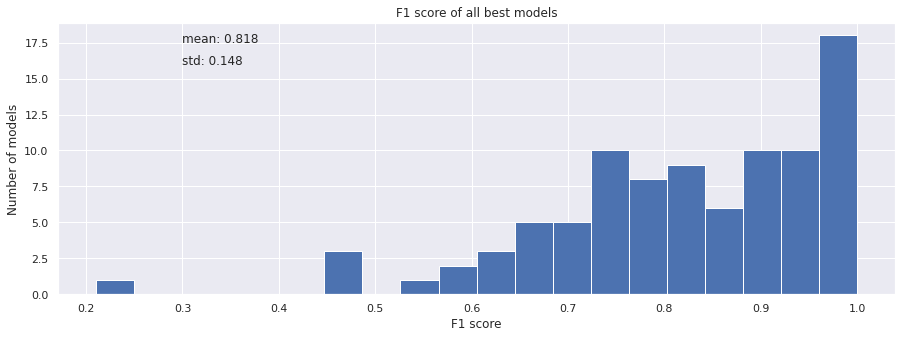

In [18]:
mes=f1_list
plt.hist(mes,bins=20)
plt.title('F1 score of all best models')
plt.xlabel('F1 score') 
plt.ylabel('Number of models')
txtm="mean: " +str(round(np.mean(mes),3))
txtstd="std: " +str(round(np.std(mes),3))
plt.text(0.3, 17.5, txtm)
plt.text(0.3, 16, txtstd)
plt.show()